In [1]:
import numpy as np
import xgboost
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import make_moons, load_iris, fetch_openml
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [2]:

def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

In [3]:
# Prepare data
X,y = make_moons(n_samples = 500, noise = 0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [4]:
# Classifiers
log_reg = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

# VOTING CLASSIFIERS

## Hard Voting

In [5]:
# Voting Classifier 
voting_clf = VotingClassifier(estimators = [("logistic", log_reg),("randomf", rnd_clf),("svm", svm_clf)],
                             voting="hard")
#voting_clf.fit(X_train, y_train)

In [6]:
# Evaluation on test set
for classifier in (log_reg, rnd_clf, svm_clf, voting_clf):
    classifier.fit(X_train, y_train)
    preds = classifier.predict(X_test)
    print(classifier.__class__.__name__, accuracy_score(y_test, preds))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


### Soft Voting

In [7]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(estimators = [("logistic", log_reg),("randomf", rnd_clf),("svm", svm_clf)],
                             voting="soft")

for classifier in (log_reg, rnd_clf, svm_clf, voting_clf):
    classifier.fit(X_train, y_train)
    preds = classifier.predict(X_test)
    print(classifier.__class__.__name__, accuracy_score(y_test, preds))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


# BAGGING AND PASTING

In [8]:
# A single Decision Tree Classifier
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
# Evaluation
pred = tree_clf.predict(X_test)
accuracy_score(y_test, pred)

0.856

In [9]:
# Bagging ensemble of 500 trees
bag_clf = BaggingClassifier(DecisionTreeClassifier(random_state=42), n_estimators=500,
                           max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)

# Evaluation
pred = bag_clf.predict(X_test)
accuracy_score(y_test, pred)

0.904

## Out-of-Bag (oob) evaluation

In [10]:
bag_clf = BaggingClassifier( DecisionTreeClassifier(random_state=42), n_estimators=500,
                           bootstrap=True, n_jobs=-1, random_state=42, oob_score=True)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_ # oob evaluation

0.8986666666666666

In [11]:
# The oob decision function for each training instance
# It returns the class probabilities for each training instance.

bag_clf.oob_decision_function_


array([[0.32352941, 0.67647059],
       [0.35625   , 0.64375   ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.06145251, 0.93854749],
       [0.35465116, 0.64534884],
       [0.01142857, 0.98857143],
       [0.98930481, 0.01069519],
       [0.97409326, 0.02590674],
       [0.7370892 , 0.2629108 ],
       [0.0049505 , 0.9950495 ],
       [0.75      , 0.25      ],
       [0.82681564, 0.17318436],
       [0.98461538, 0.01538462],
       [0.06315789, 0.93684211],
       [0.00490196, 0.99509804],
       [0.99004975, 0.00995025],
       [0.92513369, 0.07486631],
       [1.        , 0.        ],
       [0.03409091, 0.96590909],
       [0.34502924, 0.65497076],
       [0.91666667, 0.08333333],
       [1.        , 0.        ],
       [0.96319018, 0.03680982],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.65420561, 0.34579439],
       [0.

In [12]:
oob_pred = bag_clf.predict(X_test)
accuracy_score(y_test, oob_pred)

0.912

# RANDOM FORESTS

In [13]:
# BaggingClassifier with a DecisionTreeClassifier 
bag_clf = BaggingClassifier(DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
                             n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)

# Evaluation
bag_pred = bag_clf.predict(X_test)
accuracy_score(y_test, bag_pred)

0.92

In [14]:
# RandomForestClassifier with 500 trees (each limited to maximum 16 nodes), using all available CPU cores:
rnd_clf = RandomForestClassifier(n_estimators=500,max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

# Evaluation
rnd_preds = rnd_clf.predict(X_test)
accuracy_score(y_test,rnd_preds)

0.912

In [15]:
# Comparing predictions of a Random Forest and Bagging with Decision Tree clf
np.sum(bag_pred == rnd_preds) / len(y_test)

0.976

## Extra-Trees

In [16]:
# RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=500,max_leaf_nodes=16,
                                       n_jobs=-1, random_state=42)

# Evaluation with cv
forest_scores = cross_val_score(random_forest,X_train, y_train, cv = 3, scoring = "accuracy")
forest_scores = forest_scores.mean()
forest_scores

0.9146666666666667

In [17]:
# ExtraTreesClassifier
extra_trees = ExtraTreesClassifier(n_estimators=500,max_leaf_nodes=16, n_jobs=-1, random_state=42)

# Evaluation with cv
extra_tree_scores = cross_val_score(extra_trees,X_train, y_train, cv = 3, scoring = "accuracy")
extra_tree_scores = extra_tree_scores.mean()
extra_tree_scores

0.904

## Feature Importance

###### Train a RandomForestClassifier on the iris dataset and output each feature's importance

In [18]:
# Load data
iris = load_iris()
X = iris["data"]
y = iris["target"]

# RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(X, y)

# Feature importance
for feature, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(feature, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


###### Train a RandomForestClassifier on the MNIST dataset and plot each pixel’s importance

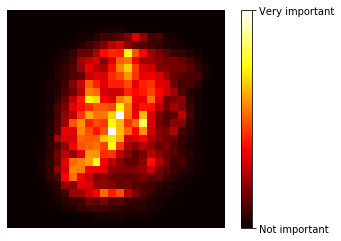

In [19]:
# load data
mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

X = mnist["data"]
y = mnist["target"]

# RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X, y)

# Plot each pixel's importance
ftr_imp = rnd_clf.feature_importances_

image = ftr_imp.reshape(28,28)
plt.imshow(image, cmap = mpl.cm.hot, interpolation="nearest")
plt.axis("off")
cbar = plt.colorbar(ticks=[ftr_imp.min(), ftr_imp.max()])
cbar.ax.set_yticklabels(["Not important", "Very important"])
plt.show()

# BOOSTING

## AdaBoost

In [20]:
# Training AdaBoost classifier on 200 Decision Tree with max_depth 1
adaBst_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                               n_estimators=200, algorithm="SAMME.R",
                               learning_rate=0.5, random_state=42)
adaBst_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                             

## Gradient Bossting

In [21]:
# Create a noisy quadratic training set
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0]**2 + 0.05 * np.random.randn(100)

In [22]:
# Train the first decision tree regressor
tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X,y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [23]:
# Train the second decision tree regressor
pred1 = tree_reg1.predict(X)
y2 = y - pred1
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X,y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [24]:
# Train the third decision tree regressor
pred2 = tree_reg2.predict(X)
y3 = y2 - pred2
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X,y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [25]:
# Making prediction on a new instance 
X_new = np.array([[0.8]])
y_pred = 0
for tree in (tree_reg1,tree_reg2, tree_reg3):
    y_pred = y_pred + tree.predict(X_new)
y_pred

array([0.75026781])

In [26]:
# Training GradientBoostingRegressor ensemble
gradBst_reg = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gradBst_reg.fit(X,y)
y_grd_pred = gradBst_reg.predict(X_new)
y_grd_pred

array([0.75026781])

### Gradient Boosting with Early Stopping

In [27]:
# Split training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y,random_state=49)

# Train a GBRT ensemble with 120 trees
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

# Measure the validation error at each stage of training to find the optimal number of trees
errors = [mean_squared_error(y_val,y_pred)
         for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

# And finally train another GBRT ensemble using the optimal number of trees
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators,random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=56,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

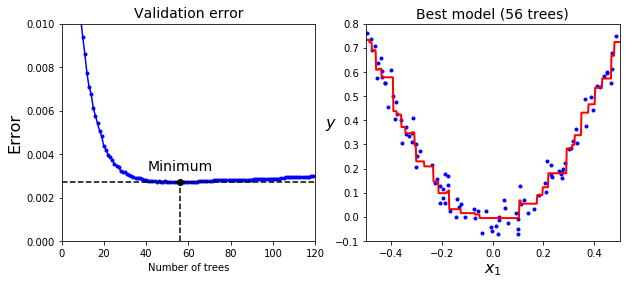

In [28]:
min_error = np.min(errors)

plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)
plt.show()

#### Implement early stopping by actually stopping training early

In [29]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1,120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5: # stops training when the val error doesn't improve for 5 iterations in a row:
            break # early stopping
print(gbrt.n_estimators)
print("Minimum validation MSE:", min_val_error)

61
Minimum validation MSE: 0.002712853325235463


### XGBoost

In [30]:
xgb_reg = xgboost.XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)
print("Validation MSE:", val_error)

[14:03:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation MSE: 0.0028512559726563943


In [31]:
# XGBoost is automatically taking care of early stopping
xgb_reg.fit(X_train, y_train,
            eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)
print("Validation MSE:", val_error)

[14:03:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.286719
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.258221
[2]	validation_0-rmse:0.232634
[3]	validation_0-rmse:0.210526
[4]	validation_0-rmse:0.190232
[5]	validation_0-rmse:0.172196
[6]	validation_0-rmse:0.156394
[7]	validation_0-rmse:0.142241
[8]	validation_0-rmse:0.129789
[9]	validation_0-rmse:0.118752
[10]	validation_0-rmse:0.108388
[11]	validation_0-rmse:0.100155
[12]	validation_0-rmse:0.09208
[13]	validation_0-rmse:0.084791
[14]	validation_0-rmse:0.078699
[15]	validation_0-rmse:0.073248
[16]	validation_0-rmse:0.069391
[17]	validation_0-rmse:0.066277
[18]	validation_0-rmse:0.063458
[19]	validation_0-rmse:0.060326
[20]	validation_0-rmse:0.0578
[21]	validation_0-rmse:0.055643
[22]	validation_0-rmse:0.053943
[23]	validation_0-rmse:0.053138
[24]	validation_0-rmse:0.052415
[25]	validation_0-rmse:0.051821
[